<a href="https://www.kaggle.com/code/dataranch/house-rent-feature-imporatance-eda?scriptVersionId=106681553" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**House Rent Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

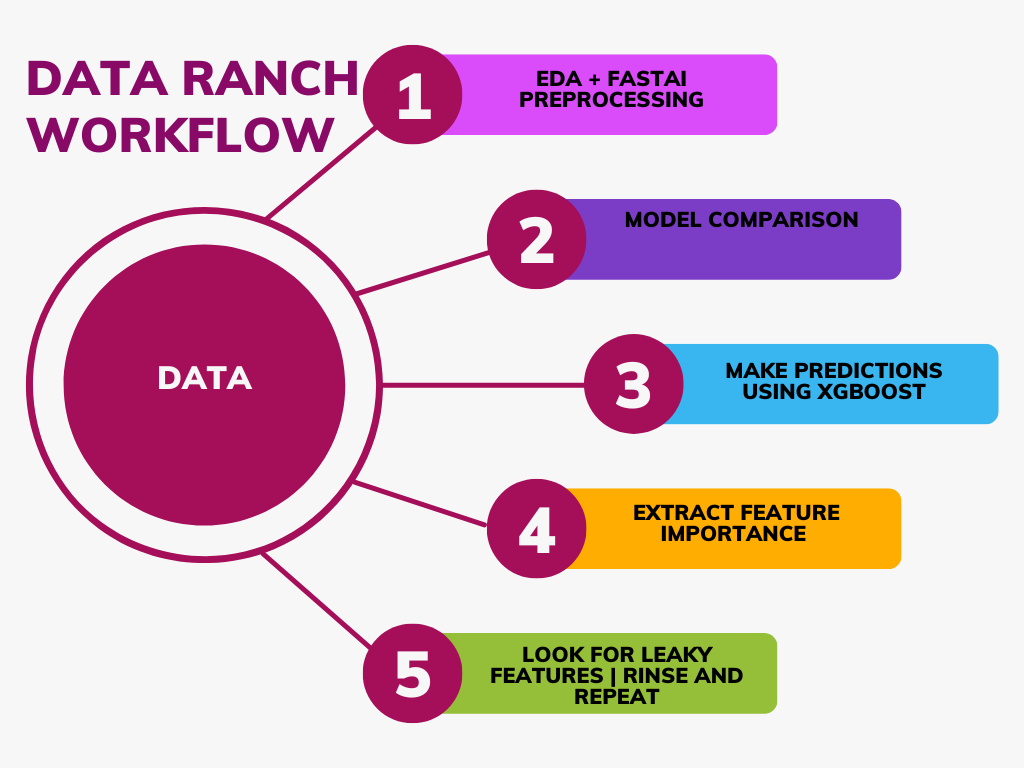

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.1/248.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 68.4 MB/s eta 0:00:00
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux

In [3]:
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 61.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.5
    Uninstalling pandas-1.0.5:
      Successfully uninstalled pandas-1.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.1 which is incompatible.
tfx-bsl 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.3 MB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.1 which is incompatible.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.19.1 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,

In [6]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [7]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'house-rent-prediction-dataset'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = True
SEP_PERCENT = True
SHUFFLE_DATA = True

In [8]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/house-rent-prediction-dataset
CSV!


In [9]:
df

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner
...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2022-05-18,2,15000,1000,3 out of 5,Carpet Area,Bandam Kommu,Hyderabad,Semi-Furnished,Bachelors/Family,2,Contact Owner
4742,2022-05-15,3,29000,2000,1 out of 4,Super Area,"Manikonda, Hyderabad",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Owner
4743,2022-07-10,3,35000,1750,3 out of 5,Carpet Area,"Himayath Nagar, NH 7",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Agent
4744,2022-07-06,3,45000,1500,23 out of 34,Carpet Area,Gachibowli,Hyderabad,Semi-Furnished,Family,2,Contact Agent


In [10]:
df.isna().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

<AxesSubplot:>

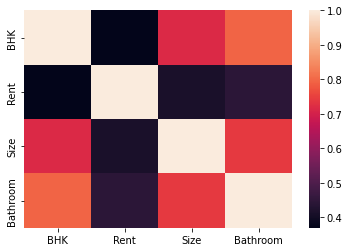

In [11]:
sns.heatmap(df.corr())

In [12]:
df.head().style.background_gradient(cmap = "inferno")

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [13]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
BHK,4746.00,2.08,0.83,1.00,2.00,2.00,3.00,6.00
Rent,4746.00,34993.45,78106.41,1200.00,10000.00,16000.00,33000.00,3500000.00
Size,4746.00,967.49,634.20,10.00,550.00,850.00,1200.00,8000.00
Bathroom,4746.00,1.97,0.88,1.00,1.00,2.00,2.00,10.00


In [14]:
df.columns

Index(['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'Area Type',
       'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred',
       'Bathroom', 'Point of Contact'],
      dtype='object')

Target Variable: Bathroom
CATS=====================
['Posted On', 'BHK', 'Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact']
CONTS=====================
['Rent', 'Size', 'Floor', 'Area Locality']
12
Could not convert Floor to float.
Could not convert Area Locality to float.
Looping through continuous variables to find breakpoint
Error with  Floor
Error with  Area Locality
Continuous variables that made the cut : ['Rent', 'Size']
Categorical variables that made the cut : ['Posted On', 'BHK', 'Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact']
Tabular Object size: 4746


  5%|▍         | 2/42 [00:00<00:03, 12.67it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5692480252683235, 'Adjusted R-Squared': 0.566043706646515, 'RMSE': 0.5587054904311638, 'Time taken': 0.08281302452087402}
{'Model': 'BaggingRegressor', 'R-Squared': 0.612304195418217, 'Adjusted R-Squared': 0.6094201671163334, 'RMSE': 0.5300475742903742, 'Time taken': 0.07479357719421387}


 14%|█▍        | 6/42 [00:00<00:01, 25.60it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.6341969136684831, 'Adjusted R-Squared': 0.631475742994391, 'RMSE': 0.5148645416976532, 'Time taken': 0.01834845542907715}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.4308083571834965, 'Adjusted R-Squared': 0.4265742004356585, 'RMSE': 0.6422417853980383, 'Time taken': 0.03655219078063965}
{'Model': 'DummyRegressor', 'R-Squared': -1.16593118550945e-05, 'Adjusted R-Squared': -0.007450640837022959, 'RMSE': 0.8512788283419105, 'Time taken': 0.02082681655883789}
{'Model': 'ElasticNet', 'R-Squared': 0.2267220995535436, 'Adjusted R-Squared': 0.22096976660654544, 'RMSE': 0.7485780698472813, 'Time taken': 0.023115158081054688}
{'Model': 'ElasticNetCV', 'R-Squared': 0.63415924709934, 'Adjusted R-Squared': 0.6314377962276029, 'RMSE': 0.5148910486933331, 'Time taken': 0.17691993713378906}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.3634404095510648, 'Adjusted R-Squared': 0.3587051097283841, 'RMSE': 0.6791861692634366, 'Time taken': 0.05137205123901

 21%|██▏       | 9/42 [00:01<00:04,  7.57it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.4851759124933607, 'Adjusted R-Squared': 0.481346190269613, 'RMSE': 0.6107995801693736, 'Time taken': 0.5146911144256592}
{'Model': 'GammaRegressor', 'R-Squared': 0.49436338737798025, 'Adjusted R-Squared': 0.4906020098133106, 'RMSE': 0.6053249255451592, 'Time taken': 0.027390718460083008}


 26%|██▌       | 11/42 [00:03<00:12,  2.41it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -537.1476995633654, 'Adjusted R-Squared': -541.1509236833905, 'RMSE': 19.747860229628916, 'Time taken': 2.1384687423706055}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': 0.5039099765471219, 'Adjusted R-Squared': 0.5002196150549113, 'RMSE': 0.5995833265663463, 'Time taken': 0.026568174362182617}


 31%|███       | 13/42 [00:03<00:09,  2.98it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.694253445393439, 'Adjusted R-Squared': 0.6919790289404677, 'RMSE': 0.4707063818807545, 'Time taken': 0.2737762928009033}


 33%|███▎      | 14/42 [00:03<00:10,  2.78it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6898036649901167, 'Adjusted R-Squared': 0.6874961470888742, 'RMSE': 0.4741192970383296, 'Time taken': 0.46798086166381836}


 38%|███▊      | 16/42 [00:04<00:08,  2.91it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.5623149978473945, 'Adjusted R-Squared': 0.5590591051640064, 'RMSE': 0.5631837733530527, 'Time taken': 0.6137874126434326}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6086717864169306, 'Adjusted R-Squared': 0.6057607370066421, 'RMSE': 0.5325248526136708, 'Time taken': 0.09804511070251465}


 48%|████▊     | 20/42 [00:06<00:06,  3.22it/s]

{'Model': 'KernelRidge', 'R-Squared': -4.747312666353215, 'Adjusted R-Squared': -4.790066320619393, 'RMSE': 2.0408059549168795, 'Time taken': 1.3233888149261475}
{'Model': 'Lars', 'R-Squared': 0.6341539910291492, 'Adjusted R-Squared': 0.6314325010580588, 'RMSE': 0.5148947474252961, 'Time taken': 0.027385711669921875}
{'Model': 'LarsCV', 'R-Squared': 0.6341539910291492, 'Adjusted R-Squared': 0.6314325010580588, 'RMSE': 0.5148947474252961, 'Time taken': 0.06038975715637207}
{'Model': 'Lasso', 'R-Squared': -1.16593118550945e-05, 'Adjusted R-Squared': -0.007450640837022959, 'RMSE': 0.8512788283419105, 'Time taken': 0.05595135688781738}


 55%|█████▍    | 23/42 [00:06<00:04,  4.68it/s]

{'Model': 'LassoCV', 'R-Squared': 0.6341297374171291, 'Adjusted R-Squared': 0.6314080670259706, 'RMSE': 0.5149118145111236, 'Time taken': 0.23611783981323242}
{'Model': 'LassoLars', 'R-Squared': -1.16593118550945e-05, 'Adjusted R-Squared': -0.007450640837022959, 'RMSE': 0.8512788283419105, 'Time taken': 0.04898834228515625}
{'Model': 'LassoLarsCV', 'R-Squared': 0.6341539910291492, 'Adjusted R-Squared': 0.6314325010580588, 'RMSE': 0.5148947474252961, 'Time taken': 0.06989383697509766}
{'Model': 'LassoLarsIC', 'R-Squared': 0.6341539910291492, 'Adjusted R-Squared': 0.6314325010580588, 'RMSE': 0.5148947474252961, 'Time taken': 0.027853727340698242}
{'Model': 'LinearRegression', 'R-Squared': 0.6341539910291492, 'Adjusted R-Squared': 0.6314325010580588, 'RMSE': 0.5148947474252962, 'Time taken': 0.02370929718017578}
{'Model': 'LinearSVR', 'R-Squared': 0.562314981091682, 'Adjusted R-Squared': 0.5590590882836499, 'RMSE': 0.5631837841331174, 'Time taken': 0.0441889762878418}


 64%|██████▍   | 27/42 [00:13<00:14,  1.04it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.6593483799710769, 'Adjusted R-Squared': 0.6568143084086937, 'RMSE': 0.49684912576698687, 'Time taken': 6.6450355052948}


 76%|███████▌  | 32/42 [00:15<00:06,  1.60it/s]

{'Model': 'NuSVR', 'R-Squared': 0.6317056539452544, 'Adjusted R-Squared': 0.6289659510521797, 'RMSE': 0.5166147795909867, 'Time taken': 2.180000066757202}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.6094244035027336, 'Adjusted R-Squared': 0.6065189527317656, 'RMSE': 0.5320125202841927, 'Time taken': 0.011936187744140625}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.6298738566764646, 'Adjusted R-Squared': 0.6271205272362257, 'RMSE': 0.5178979377053373, 'Time taken': 0.03529191017150879}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.13913805754074438, 'Adjusted R-Squared': -0.14761198570523448, 'RMSE': 0.9085680933553405, 'Time taken': 0.029675722122192383}
{'Model': 'PoissonRegressor', 'R-Squared': 0.5887382108074236, 'Adjusted R-Squared': 0.5856788776253321, 'RMSE': 0.5459193410786585, 'Time taken': 0.033286333084106445}
{'Model': 'RANSACRegressor', 'R-Squared': 0.6109689236307878, 'Adjusted R-Squared': 0.6080749623825576, 'RMSE': 0.530959564064111, 'Time

 81%|████████  | 34/42 [00:16<00:04,  1.80it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.6106305168445272, 'Adjusted R-Squared': 0.607734038223817, 'RMSE': 0.5311904469844477, 'Time taken': 0.6407907009124756}
{'Model': 'Ridge', 'R-Squared': 0.6341653762218082, 'Adjusted R-Squared': 0.6314439709439683, 'RMSE': 0.5148867355550508, 'Time taken': 0.011538267135620117}
{'Model': 'RidgeCV', 'R-Squared': 0.6341653762217065, 'Adjusted R-Squared': 0.631443970943866, 'RMSE': 0.5148867355551223, 'Time taken': 0.0216677188873291}
{'Model': 'SGDRegressor', 'R-Squared': 0.6336671507669844, 'Adjusted R-Squared': 0.630942039242403, 'RMSE': 0.5152372250654002, 'Time taken': 0.027909040451049805}


 90%|█████████ | 38/42 [00:17<00:01,  2.43it/s]

{'Model': 'SVR', 'R-Squared': 0.6551020762458148, 'Adjusted R-Squared': 0.6525364168767613, 'RMSE': 0.49993620671325645, 'Time taken': 0.7761516571044922}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.6341539910291492, 'Adjusted R-Squared': 0.6314325010580588, 'RMSE': 0.5148947474252962, 'Time taken': 0.013840198516845703}
{'Model': 'TweedieRegressor', 'R-Squared': 0.5039099765471219, 'Adjusted R-Squared': 0.5002196150549113, 'RMSE': 0.5995833265663463, 'Time taken': 0.019368648529052734}


 98%|█████████▊| 41/42 [00:17<00:00,  2.84it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.6109879137360166, 'Adjusted R-Squared': 0.6080940937531814, 'RMSE': 0.5309466, 'Time taken': 0.6272938251495361}


100%|██████████| 42/42 [00:18<00:00,  2.28it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.6907484352531279, 'Adjusted R-Squared': 0.6884479453984753, 'RMSE': 0.4733967298241635, 'Time taken': 0.6909182071685791}
Project: house-rent-prediction-dataset
house-rent-prediction-dataset
Target: Bathroom
Bathroom
Target Standard Deviation: 0.8883729878662195
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.69       0.69  0.47        0.27
LGBMRegressor                                0.69       0.69  0.47        0.69
HistGradientBoostingRegressor                0.69       0.69  0.47        0.47
MLPRegressor                                 0.66       0.66  0.50        6.65
SVR                                          0.65       0.66  0.50        0.78
BayesianRidge                                0.63       0.63  0.51        0.02
Ridge                                        0.63       0.63  0

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,4.092300,1.679376,1.295908,00:02
1,1.812723,1.473286,1.213790,00:02
2,1.037850,1.151983,1.073305,00:02
3,0.618043,0.655355,0.809540,00:02
4,0.477144,0.686430,0.828510,00:02


Better model found at epoch 0 with _rmse value: 1.2959076166152954.
Better model found at epoch 1 with _rmse value: 1.213789701461792.
Better model found at epoch 2 with _rmse value: 1.0733047723770142.
Better model found at epoch 3 with _rmse value: 0.8095402121543884.
No improvement since epoch 3: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       2.94
1       1       1.00
2       2       1.86
3       3       2.93
4       1       2.47
XGBoost RMSE:  0.52702934


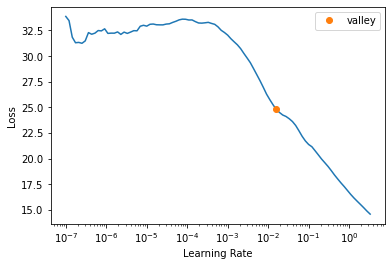

<Figure size 720x720 with 0 Axes>

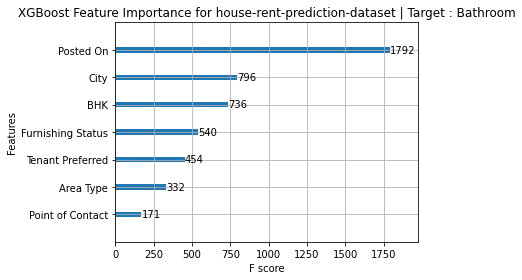

Target Variable: Size
CATS=====================
['Posted On', 'BHK', 'Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact']
CONTS=====================
['Rent', 'Floor', 'Area Locality']
11
Could not convert Floor to float.
Could not convert Area Locality to float.
Looping through continuous variables to find breakpoint
Error with  Floor
Error with  Area Locality
Continuous variables that made the cut : ['Rent']
Categorical variables that made the cut : ['Posted On', 'BHK', 'Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact']
Tabular Object size: 4746


  7%|▋         | 3/42 [00:00<00:03, 10.04it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.30855439509931815, 'Adjusted R-Squared': 0.30266975165335486, 'RMSE': 546.0943959106303, 'Time taken': 0.21960854530334473}
{'Model': 'BaggingRegressor', 'R-Squared': 0.5709598979479815, 'Adjusted R-Squared': 0.5673084928241345, 'RMSE': 430.1675571525892, 'Time taken': 0.09607243537902832}
{'Model': 'BayesianRidge', 'R-Squared': 0.6005213208811806, 'Adjusted R-Squared': 0.5971215023354886, 'RMSE': 415.0835402376159, 'Time taken': 0.017447471618652344}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.3529330468002566, 'Adjusted R-Squared': 0.34742609400706725, 'RMSE': 528.2789666750989, 'Time taken': 0.042215585708618164}
{'Model': 'DummyRegressor', 'R-Squared': -0.0008641930627872885, 'Adjusted R-Squared': -0.009382186195236564, 'RMSE': 657.0165, 'Time taken': 0.021575927734375}


 14%|█▍        | 6/42 [00:00<00:02, 15.99it/s]

{'Model': 'ElasticNet', 'R-Squared': 0.5603735144640338, 'Adjusted R-Squared': 0.5566320124594724, 'RMSE': 435.44231878202345, 'Time taken': 0.05094099044799805}


 19%|█▉        | 8/42 [00:00<00:03, 11.28it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.5638455121606362, 'Adjusted R-Squared': 0.5601335590726415, 'RMSE': 433.7194339782022, 'Time taken': 0.2292799949645996}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.46425876875214633, 'Adjusted R-Squared': 0.45969926891173907, 'RMSE': 480.6912815762621, 'Time taken': 0.03435111045837402}


 24%|██▍       | 10/42 [00:01<00:05,  5.43it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.5758890214102268, 'Adjusted R-Squared': 0.5722795662732926, 'RMSE': 427.68938057734175, 'Time taken': 0.6987013816833496}
{'Model': 'GammaRegressor', 'R-Squared': 0.5251826677341048, 'Adjusted R-Squared': 0.5211416691616291, 'RMSE': 452.53480962339114, 'Time taken': 0.02574896812438965}


 26%|██▌       | 11/42 [00:03<00:17,  1.74it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -1268.200734267409, 'Adjusted R-Squared': -1279.0024426441528, 'RMSE': 23396.660159319636, 'Time taken': 2.1564793586730957}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': 0.5071439139503477, 'Adjusted R-Squared': 0.5029493940690741, 'RMSE': 461.05079101991043, 'Time taken': 0.030216455459594727}


 31%|███       | 13/42 [00:03<00:12,  2.34it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.6689690195326239, 'Adjusted R-Squared': 0.666151734592476, 'RMSE': 377.85313489711257, 'Time taken': 0.2972743511199951}


 36%|███▌      | 15/42 [00:04<00:10,  2.64it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6743977934614651, 'Adjusted R-Squared': 0.6716267108526265, 'RMSE': 374.74200771878816, 'Time taken': 0.4813206195831299}
{'Model': 'HuberRegressor', 'R-Squared': 0.5894696643153121, 'Adjusted R-Squared': 0.5859757891179956, 'RMSE': 420.7860530886278, 'Time taken': 0.16967225074768066}


 38%|███▊      | 16/42 [00:04<00:08,  3.16it/s]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.5972857401598073, 'Adjusted R-Squared': 0.5938583847569121, 'RMSE': 416.76114, 'Time taken': 0.11468052864074707}


 45%|████▌     | 19/42 [00:06<00:08,  2.68it/s]

{'Model': 'KernelRidge', 'R-Squared': -1.5988446728271328, 'Adjusted R-Squared': -1.620962499829917, 'RMSE': 1058.7145247127214, 'Time taken': 1.3540775775909424}
{'Model': 'Lars', 'R-Squared': 0.6005198988747591, 'Adjusted R-Squared': 0.5971200682268847, 'RMSE': 415.08427901413296, 'Time taken': 0.04358792304992676}
{'Model': 'LarsCV', 'R-Squared': 0.6005198988747591, 'Adjusted R-Squared': 0.5971200682268847, 'RMSE': 415.08427901413296, 'Time taken': 0.12658262252807617}
{'Model': 'Lasso', 'R-Squared': 0.6001906481337558, 'Adjusted R-Squared': 0.5967880153519154, 'RMSE': 415.255299620075, 'Time taken': 0.05917024612426758}


 55%|█████▍    | 23/42 [00:06<00:04,  4.74it/s]

{'Model': 'LassoCV', 'R-Squared': 0.6003761360963823, 'Adjusted R-Squared': 0.5969750819355004, 'RMSE': 415.15896145920163, 'Time taken': 0.22872066497802734}
{'Model': 'LassoLars', 'R-Squared': 0.5615572038749899, 'Adjusted R-Squared': 0.5578257758228622, 'RMSE': 434.8557118634202, 'Time taken': 0.047902584075927734}
{'Model': 'LassoLarsCV', 'R-Squared': 0.6005198988747591, 'Adjusted R-Squared': 0.5971200682268847, 'RMSE': 415.08427901413296, 'Time taken': 0.0845952033996582}
{'Model': 'LassoLarsIC', 'R-Squared': 0.6005198988747591, 'Adjusted R-Squared': 0.5971200682268847, 'RMSE': 415.08427901413296, 'Time taken': 0.028913259506225586}
{'Model': 'LinearRegression', 'R-Squared': 0.6005198988747593, 'Adjusted R-Squared': 0.5971200682268849, 'RMSE': 415.0842790141329, 'Time taken': 0.023558855056762695}
{'Model': 'LinearSVR', 'R-Squared': 0.5276370166426134, 'Adjusted R-Squared': 0.5236169061459548, 'RMSE': 451.3637094479283, 'Time taken': 0.03258776664733887}


 64%|██████▍   | 27/42 [00:14<00:15,  1.02s/it]

{'Model': 'MLPRegressor', 'R-Squared': 0.6210279450155922, 'Adjusted R-Squared': 0.6178026509306185, 'RMSE': 404.28935171741045, 'Time taken': 7.261787414550781}


 76%|███████▌  | 32/42 [00:15<00:05,  1.80it/s]

{'Model': 'NuSVR', 'R-Squared': 0.1477179585359113, 'Adjusted R-Squared': 0.14046449435323816, 'RMSE': 606.2899625160236, 'Time taken': 0.908935546875}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.5111506092047807, 'Adjusted R-Squared': 0.5069901888575874, 'RMSE': 459.17290027857683, 'Time taken': 0.013559818267822266}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.5952272562533669, 'Adjusted R-Squared': 0.591782381838502, 'RMSE': 417.82492114509796, 'Time taken': 0.0378265380859375}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.5907623992653983, 'Adjusted R-Squared': 0.587279526067657, 'RMSE': 420.1230159223224, 'Time taken': 0.0314788818359375}
{'Model': 'PoissonRegressor', 'R-Squared': 0.6530943189745843, 'Adjusted R-Squared': 0.6501419301998999, 'RMSE': 386.8070807995219, 'Time taken': 0.04248547554016113}
{'Model': 'RANSACRegressor', 'R-Squared': 0.5631702840591573, 'Adjusted R-Squared': 0.5594525843490223, 'RMSE': 434.055033288673, 'Time taken': 0.14501

 88%|████████▊ | 37/42 [00:16<00:01,  2.72it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.6041457808581316, 'Adjusted R-Squared': 0.6007768087803285, 'RMSE': 413.196228355868, 'Time taken': 0.8685595989227295}
{'Model': 'Ridge', 'R-Squared': 0.6005203298044455, 'Adjusted R-Squared': 0.5971205028240578, 'RMSE': 415.084055132911, 'Time taken': 0.013411521911621094}
{'Model': 'RidgeCV', 'R-Squared': 0.6005210724498395, 'Adjusted R-Squared': 0.5971212517898381, 'RMSE': 415.083669305511, 'Time taken': 0.030387401580810547}
{'Model': 'SGDRegressor', 'R-Squared': 0.5970302683851225, 'Adjusted R-Squared': 0.5936007387543576, 'RMSE': 416.89330679264435, 'Time taken': 0.0742349624633789}


 93%|█████████▎| 39/42 [00:17<00:01,  2.49it/s]

{'Model': 'SVR', 'R-Squared': 0.1583850906082942, 'Adjusted R-Squared': 0.15122241052836483, 'RMSE': 602.4838638381634, 'Time taken': 0.9869675636291504}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.6005198988747593, 'Adjusted R-Squared': 0.5971200682268849, 'RMSE': 415.0842790141329, 'Time taken': 0.017945289611816406}
{'Model': 'TweedieRegressor', 'R-Squared': 0.5071439139503477, 'Adjusted R-Squared': 0.5029493940690741, 'RMSE': 461.05079101991043, 'Time taken': 0.045484066009521484}


100%|██████████| 42/42 [00:17<00:00,  2.38it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.6347081369687524, 'Adjusted R-Squared': 0.6315992700493376, 'RMSE': 396.92526, 'Time taken': 0.2534773349761963}
{'Model': 'LGBMRegressor', 'R-Squared': 0.6753397594154715, 'Adjusted R-Squared': 0.6725766935381564, 'RMSE': 374.19955149704185, 'Time taken': 0.10662651062011719}
Project: house-rent-prediction-dataset
house-rent-prediction-dataset
Target: Size
Size
Target Standard Deviation: 628.3014526367188
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
LGBMRegressor                                0.67       0.68   374.20   
HistGradientBoostingRegressor                0.67       0.67   374.74   
GradientBoostingRegressor                    0.67       0.67   377.85   
PoissonRegressor                             0.65       0.65   386.81   
XGBRegressor                                 0.63       0.63   396.93   
MLPRegressor                          

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,1269943.250000,1315165.750000,1146.806763,00:02
1,734699.625000,638034.312500,798.770508,00:02
2,387654.593750,299945.906250,547.673157,00:02
3,282190.562500,297905.906250,545.807556,00:02
4,236608.828125,243533.671875,493.491302,00:02
5,213132.296875,241669.796875,491.599213,00:02
6,202263.125000,206681.046875,454.621887,00:02
7,191924.937500,225958.515625,475.350952,00:02


Better model found at epoch 0 with _rmse value: 1146.8067626953125.
Better model found at epoch 1 with _rmse value: 798.7705078125.
Better model found at epoch 2 with _rmse value: 547.6731567382812.
Better model found at epoch 3 with _rmse value: 545.8075561523438.
Better model found at epoch 4 with _rmse value: 493.4913024902344.
Better model found at epoch 5 with _rmse value: 491.5992126464844.
Better model found at epoch 6 with _rmse value: 454.62188720703125.
No improvement since epoch 6: early stopping


,Posted On,BHK,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Size,Size_pred
0,42.00,3.00,2.00,1.00,2.00,2.00,3.00,1.00,1950.00,1377.30
1,79.00,3.00,2.00,6.00,1.00,1.00,3.00,1.00,1350.00,1482.63
2,69.00,1.00,3.00,4.00,3.00,2.00,1.00,3.00,450.00,577.88
3,64.00,1.00,2.00,5.00,3.00,1.00,1.00,3.00,700.00,707.10
4,6.00,1.00,2.00,5.00,2.00,2.00,1.00,3.00,130.00,552.65
5,6.00,1.00,3.00,3.00,2.00,2.00,1.00,3.00,700.00,537.80
6,65.00,2.00,3.00,4.00,3.00,3.00,2.00,3.00,760.00,1271.77
7,56.00,1.00,3.00,6.00,3.00,3.00,1.00,3.00,450.00,693.90
8,40.00,5.00,2.00,6.00,2.00,2.00,5.00,1.00,3000.00,2000.68


<Figure size 432x288 with 0 Axes>

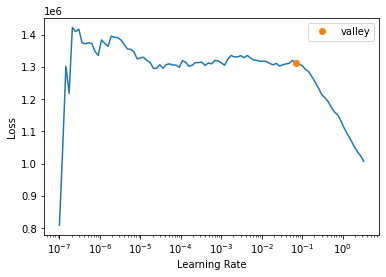

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0 1000.00     860.17
1  500.00     998.93
2 1000.00     927.13
3  450.00     301.28
4 1100.00     797.58
XGBoost RMSE:  396.8362


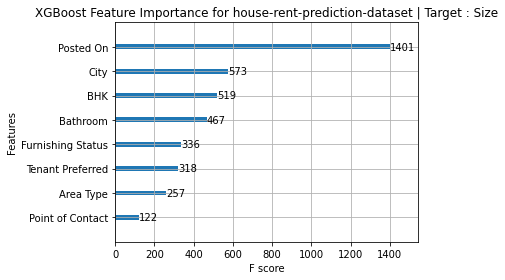

Target Variable: Rent
CATS=====================
['Posted On', 'BHK', 'Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact']
CONTS=====================
['Size', 'Floor', 'Area Locality']
11
Could not convert Floor to float.
Could not convert Area Locality to float.
Looping through continuous variables to find breakpoint
Error with  Floor
Error with  Area Locality
Continuous variables that made the cut : ['Size']
Categorical variables that made the cut : ['Posted On', 'BHK', 'Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact']
Tabular Object size: 4746


  5%|▍         | 2/42 [00:00<00:05,  7.32it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -1.2023776254703429, 'Adjusted R-Squared': -1.2211212648360479, 'RMSE': 87119.05177039851, 'Time taken': 0.18729376792907715}
{'Model': 'BaggingRegressor', 'R-Squared': 0.03729500808425368, 'Adjusted R-Squared': 0.029101774110502632, 'RMSE': 57598.85609987177, 'Time taken': 0.09973835945129395}
{'Model': 'BayesianRidge', 'R-Squared': 0.39304324639272903, 'Adjusted R-Squared': 0.3878776570003267, 'RMSE': 45734.73012642897, 'Time taken': 0.03217291831970215}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -7.100857729392237, 'Adjusted R-Squared': -7.169801199429617, 'RMSE': 167083.18645231065, 'Time taken': 0.04510998725891113}


 12%|█▏        | 5/42 [00:00<00:02, 15.87it/s]

{'Model': 'DummyRegressor', 'R-Squared': -6.938006070544844e-05, 'Adjusted R-Squared': -0.008580608827179592, 'RMSE': 58705.973, 'Time taken': 0.02229142189025879}
{'Model': 'ElasticNet', 'R-Squared': 0.38631832875548844, 'Adjusted R-Squared': 0.38109550602149256, 'RMSE': 45987.39644218348, 'Time taken': 0.03965306282043457}


 17%|█▋        | 7/42 [00:00<00:03, 10.59it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.04921722400245465, 'Adjusted R-Squared': 0.041125455696092605, 'RMSE': 57241.090570548724, 'Time taken': 0.23914575576782227}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.3103647917374811, 'Adjusted R-Squared': 0.3044955559224809, 'RMSE': 48750.26260183147, 'Time taken': 0.033277273178100586}


 21%|██▏       | 9/42 [00:01<00:06,  5.17it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.3653099864620961, 'Adjusted R-Squared': 0.35990836932560333, 'RMSE': 46767.92258642726, 'Time taken': 0.6898422241210938}
{'Model': 'GammaRegressor', 'R-Squared': 0.38758976144842505, 'Adjusted R-Squared': 0.38237775941819885, 'RMSE': 45939.73313554229, 'Time taken': 0.034723520278930664}


 26%|██▌       | 11/42 [00:03<00:15,  2.00it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -6064.468017912359, 'Adjusted R-Squared': -6116.089022320124, 'RMSE': 4571928.240094758, 'Time taken': 2.125969171524048}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': 0.3638980464100632, 'Adjusted R-Squared': 0.3584844127624892, 'RMSE': 46819.91396621683, 'Time taken': 0.03187370300292969}


 31%|███       | 13/42 [00:03<00:11,  2.57it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.5392565271490579, 'Adjusted R-Squared': 0.535335306103518, 'RMSE': 39847.111254192176, 'Time taken': 0.296846866607666}


 38%|███▊      | 16/42 [00:04<00:07,  3.40it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.5143982096406416, 'Adjusted R-Squared': 0.5102654284460939, 'RMSE': 40907.91889809478, 'Time taken': 0.4534413814544678}
{'Model': 'HuberRegressor', 'R-Squared': 0.26997241753395307, 'Adjusted R-Squared': 0.26375941683211435, 'RMSE': 50157.61542859374, 'Time taken': 0.07148981094360352}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.5418367195836202, 'Adjusted R-Squared': 0.5379374576226297, 'RMSE': 39735.383, 'Time taken': 0.11510205268859863}


 45%|████▌     | 19/42 [00:06<00:08,  2.86it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.04888111775366133, 'Adjusted R-Squared': 0.040786488968586054, 'RMSE': 57251.207175906566, 'Time taken': 1.3415498733520508}
{'Model': 'Lars', 'R-Squared': 0.3923233622458814, 'Adjusted R-Squared': 0.38715164617988884, 'RMSE': 45761.84404388288, 'Time taken': 0.038680315017700195}
{'Model': 'LarsCV', 'R-Squared': 0.3923233622458814, 'Adjusted R-Squared': 0.38715164617988884, 'RMSE': 45761.84404388288, 'Time taken': 0.10438346862792969}
{'Model': 'Lasso', 'R-Squared': 0.3923260390238349, 'Adjusted R-Squared': 0.38715434573893137, 'RMSE': 45761.74325472749, 'Time taken': 0.019817113876342773}


 55%|█████▍    | 23/42 [00:06<00:03,  4.78it/s]

{'Model': 'LassoCV', 'R-Squared': 0.3924062184916315, 'Adjusted R-Squared': 0.38723520758517727, 'RMSE': 45758.72414127629, 'Time taken': 0.22976160049438477}
{'Model': 'LassoLars', 'R-Squared': 0.3924621270879016, 'Adjusted R-Squared': 0.387291591999288, 'RMSE': 45756.61881616768, 'Time taken': 0.03814196586608887}
{'Model': 'LassoLarsCV', 'R-Squared': 0.3923233622458814, 'Adjusted R-Squared': 0.38715164617988884, 'RMSE': 45761.84404388288, 'Time taken': 0.11179447174072266}
{'Model': 'LassoLarsIC', 'R-Squared': 0.3923233622458814, 'Adjusted R-Squared': 0.38715164617988884, 'RMSE': 45761.84404388288, 'Time taken': 0.024509191513061523}
{'Model': 'LinearRegression', 'R-Squared': 0.39232336224588116, 'Adjusted R-Squared': 0.3871516461798886, 'RMSE': 45761.84404388289, 'Time taken': 0.021436452865600586}
{'Model': 'LinearSVR', 'R-Squared': -0.27388242160081444, 'Adjusted R-Squared': -0.28472397412507666, 'RMSE': 66257.02305636907, 'Time taken': 0.02359604835510254}


 64%|██████▍   | 27/42 [00:12<00:12,  1.22it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.13797628308317944, 'Adjusted R-Squared': -0.14766118762005753, 'RMSE': 62622.99756441601, 'Time taken': 5.8023645877838135}


 74%|███████▍  | 31/42 [00:13<00:05,  1.89it/s]

{'Model': 'NuSVR', 'R-Squared': -0.04773750601210058, 'Adjusted R-Squared': -0.056654420956884444, 'RMSE': 60088.79459495739, 'Time taken': 0.935307502746582}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.29077092056520293, 'Adjusted R-Squared': 0.2847349283998004, 'RMSE': 49437.956794987724, 'Time taken': 0.019112110137939453}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.38679268746626116, 'Adjusted R-Squared': 0.38157390182767614, 'RMSE': 45969.61952277734, 'Time taken': 0.039650917053222656}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.24172855575317242, 'Adjusted R-Squared': 0.2352751817595824, 'RMSE': 51118.67604548091, 'Time taken': 0.06900501251220703}
{'Model': 'PoissonRegressor', 'R-Squared': 0.520168224500617, 'Adjusted R-Squared': 0.5160845498155158, 'RMSE': 40664.15469897603, 'Time taken': 0.04823422431945801}


 79%|███████▊  | 33/42 [00:13<00:03,  2.39it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -0.04919450562675309, 'Adjusted R-Squared': -0.05812382056825749, 'RMSE': 60130.56027307313, 'Time taken': 0.18147492408752441}


 88%|████████▊ | 37/42 [00:14<00:01,  3.25it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.074481388695405, 'Adjusted R-Squared': -0.08362591115238716, 'RMSE': 60850.85647962402, 'Time taken': 0.8629131317138672}
{'Model': 'Ridge', 'R-Squared': 0.3923409880849609, 'Adjusted R-Squared': 0.3871694220261095, 'RMSE': 45761.180371217255, 'Time taken': 0.015320539474487305}
{'Model': 'RidgeCV', 'R-Squared': 0.39249592834312097, 'Adjusted R-Squared': 0.3873256809247645, 'RMSE': 45755.345930367126, 'Time taken': 0.03411245346069336}
{'Model': 'SGDRegressor', 'R-Squared': 0.3913105990214637, 'Adjusted R-Squared': 0.38613026369398684, 'RMSE': 45799.961864877594, 'Time taken': 0.07863545417785645}


 93%|█████████▎| 39/42 [00:15<00:01,  2.73it/s]

{'Model': 'SVR', 'R-Squared': -0.09790810461052746, 'Adjusted R-Squared': -0.10725200337317031, 'RMSE': 61510.639487403125, 'Time taken': 1.0178215503692627}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.39232336224588116, 'Adjusted R-Squared': 0.3871516461798886, 'RMSE': 45761.84404388289, 'Time taken': 0.01641678810119629}
{'Model': 'TweedieRegressor', 'R-Squared': 0.3638980464100632, 'Adjusted R-Squared': 0.3584844127624892, 'RMSE': 46819.91396621683, 'Time taken': 0.04673957824707031}


100%|██████████| 42/42 [00:16<00:00,  2.61it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.3460657192928702, 'Adjusted R-Squared': 0.3405003211591925, 'RMSE': 47471.65, 'Time taken': 0.2488565444946289}
{'Model': 'LGBMRegressor', 'R-Squared': 0.5104958965174546, 'Adjusted R-Squared': 0.5063299041473904, 'RMSE': 41071.95873995173, 'Time taken': 0.1046900749206543}
Project: house-rent-prediction-dataset
house-rent-prediction-dataset
Target: Rent
Rent
Target Standard Deviation: 82233.796875
                               Adjusted R-Squared  R-Squared       RMSE  \
Model                                                                     
KNeighborsRegressor                          0.54       0.54   39735.38   
GradientBoostingRegressor                    0.54       0.54   39847.11   
PoissonRegressor                             0.52       0.52   40664.15   
HistGradientBoostingRegressor                0.51       0.51   40907.92   
LGBMRegressor                                0.51       0.51   41071.96   
BayesianRidge                   

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,7059432960.000000,4641426432.000000,68128.015625,00:02
1,7423468032.000000,4453030912.000000,66731.031250,00:02
2,6590648320.000000,3287527424.000000,57336.964844,00:02
3,6494846464.000000,14767291392.000000,121520.750000,00:02


Better model found at epoch 0 with _rmse value: 68128.015625.
Better model found at epoch 1 with _rmse value: 66731.03125.
Better model found at epoch 2 with _rmse value: 57336.96484375.
No improvement since epoch 2: early stopping


,Posted On,BHK,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rent,Rent_pred
0,37.00,1.00,2.00,6.00,3.00,2.00,2.00,1.00,36000.00,101243.49
1,75.00,2.00,2.00,6.00,1.00,2.00,2.00,1.00,55000.00,101243.49
2,71.00,3.00,2.00,3.00,3.00,3.00,2.00,1.00,27000.00,41443.95
3,50.00,3.00,2.00,6.00,1.00,1.00,3.00,1.00,300000.00,103071.23
4,47.00,3.00,3.00,1.00,2.00,2.00,2.00,3.00,15000.00,78130.55
5,76.00,1.00,3.00,4.00,3.00,3.00,1.00,1.00,15000.00,41684.14
6,45.00,1.00,3.00,2.00,2.00,2.00,1.00,3.00,10000.00,76608.08
7,9.00,1.00,3.00,4.00,3.00,2.00,2.00,3.00,9000.00,6784.83
8,36.00,1.00,3.00,6.00,2.00,2.00,1.00,3.00,24000.00,78410.70


<Figure size 432x288 with 0 Axes>

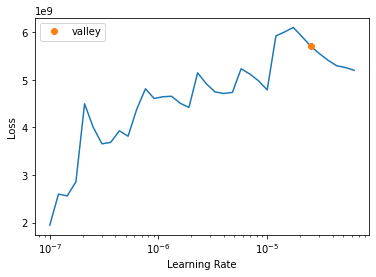

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
    actual  predicted
0 12000.00   13169.00
1 50000.00   48200.44
2  5500.00    5231.41
3 60000.00   92626.24
4 65000.00   47702.26
XGBoost RMSE:  47470.934


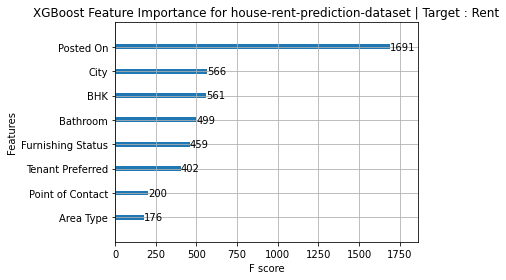

Target Variable: BHK
CATS=====================
['Posted On', 'BHK', 'Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact']
CONTS=====================
['Rent', 'Size', 'Floor', 'Area Locality']
12
Could not convert Floor to float.
Could not convert Area Locality to float.
Looping through continuous variables to find breakpoint
Error with  Floor
Error with  Area Locality
Continuous variables that made the cut : ['Rent', 'Size']
Categorical variables that made the cut : ['Posted On', 'BHK', 'Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact']
Tabular Object size: 4746


  5%|▍         | 2/42 [00:00<00:02, 13.66it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.6521241527590714, 'Adjusted R-Squared': 0.6495363409304992, 'RMSE': 0.4787386289430531, 'Time taken': 0.06504678726196289}
{'Model': 'BaggingRegressor', 'R-Squared': 0.5913433812380664, 'Adjusted R-Squared': 0.5883034276447258, 'RMSE': 0.5188784115453644, 'Time taken': 0.08110618591308594}


 10%|▉         | 4/42 [00:00<00:02, 15.80it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.6739611774890528, 'Adjusted R-Squared': 0.6715358089900341, 'RMSE': 0.46346932049472206, 'Time taken': 0.03325033187866211}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.4503622253128783, 'Adjusted R-Squared': 0.44627352773284656, 'RMSE': 0.6017618059853264, 'Time taken': 0.07786369323730469}
{'Model': 'DummyRegressor', 'R-Squared': -0.003919821589404293, 'Adjusted R-Squared': -0.01138787552258802, 'RMSE': 0.8132720513199859, 'Time taken': 0.024585723876953125}
{'Model': 'ElasticNet', 'R-Squared': 0.19512188313440304, 'Adjusted R-Squared': 0.189134479502034, 'RMSE': 0.7282012047531233, 'Time taken': 0.020107269287109375}


 17%|█▋        | 7/42 [00:00<00:02, 12.85it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.6731734172660409, 'Adjusted R-Squared': 0.6707421887016012, 'RMSE': 0.4640288894784703, 'Time taken': 0.21367239952087402}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.4856376893404495, 'Adjusted R-Squared': 0.4818114022260851, 'RMSE': 0.5821312349078372, 'Time taken': 0.029352188110351562}


 21%|██▏       | 9/42 [00:01<00:04,  6.64it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.5633232453895618, 'Adjusted R-Squared': 0.5600748529535649, 'RMSE': 0.5363723355089621, 'Time taken': 0.5433259010314941}
{'Model': 'GammaRegressor', 'R-Squared': 0.49036261053182517, 'Adjusted R-Squared': 0.48657147160910763, 'RMSE': 0.5794513438130341, 'Time taken': 0.017184019088745117}


 26%|██▌       | 11/42 [00:03<00:14,  2.21it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -563.4830680071425, 'Adjusted R-Squared': -567.6821981623498, 'RMSE': 19.284651409050465, 'Time taken': 2.107846975326538}
{'Model': 'GeneralizedLinearRegressor', 'R-Squared': 0.4926971191896732, 'Adjusted R-Squared': 0.4889233464312541, 'RMSE': 0.5781226669037849, 'Time taken': 0.025586605072021484}


 31%|███       | 13/42 [00:03<00:10,  2.81it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7036343275688894, 'Adjusted R-Squared': 0.7014296945114848, 'RMSE': 0.4418758661643936, 'Time taken': 0.27599334716796875}


 33%|███▎      | 14/42 [00:03<00:10,  2.66it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6909903375704598, 'Adjusted R-Squared': 0.688691647201696, 'RMSE': 0.45120339936195225, 'Time taken': 0.46273088455200195}


 38%|███▊      | 16/42 [00:05<00:10,  2.48it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.5905498146686498, 'Adjusted R-Squared': 0.5875039578170882, 'RMSE': 0.5193819698330473, 'Time taken': 0.9194371700286865}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6126217257500733, 'Adjusted R-Squared': 0.6097400595229219, 'RMSE': 0.5051890902027205, 'Time taken': 0.1105656623840332}


 45%|████▌     | 19/42 [00:06<00:08,  2.69it/s]

{'Model': 'KernelRidge', 'R-Squared': -5.890967726271059, 'Adjusted R-Squared': -5.942228910207189, 'RMSE': 2.1307202880467546, 'Time taken': 1.137901782989502}
{'Model': 'Lars', 'R-Squared': 0.674026321660957, 'Adjusted R-Squared': 0.6716014377625794, 'RMSE': 0.46342301644855244, 'Time taken': 0.04281210899353027}
{'Model': 'LarsCV', 'R-Squared': 0.6733344223074984, 'Adjusted R-Squared': 0.6709043914426233, 'RMSE': 0.46391457779446454, 'Time taken': 0.09198546409606934}
{'Model': 'Lasso', 'R-Squared': -0.003919821589404293, 'Adjusted R-Squared': -0.01138787552258802, 'RMSE': 0.8132720513199859, 'Time taken': 0.035228729248046875}


 57%|█████▋    | 24/42 [00:06<00:03,  5.74it/s]

{'Model': 'LassoCV', 'R-Squared': 0.6734256564662243, 'Adjusted R-Squared': 0.6709963042826574, 'RMSE': 0.46384979011136057, 'Time taken': 0.2210087776184082}
{'Model': 'LassoLars', 'R-Squared': -0.003919821589404293, 'Adjusted R-Squared': -0.01138787552258802, 'RMSE': 0.8132720513199859, 'Time taken': 0.023086071014404297}
{'Model': 'LassoLarsCV', 'R-Squared': 0.6733344223074984, 'Adjusted R-Squared': 0.6709043914426233, 'RMSE': 0.46391457779446454, 'Time taken': 0.052965641021728516}
{'Model': 'LassoLarsIC', 'R-Squared': 0.6735322064398475, 'Adjusted R-Squared': 0.6711036468703245, 'RMSE': 0.4637741148236214, 'Time taken': 0.037447452545166016}
{'Model': 'LinearRegression', 'R-Squared': 0.6740263216609568, 'Adjusted R-Squared': 0.6716014377625792, 'RMSE': 0.4634230164485525, 'Time taken': 0.02357029914855957}
{'Model': 'LinearSVR', 'R-Squared': 0.5905498009591302, 'Adjusted R-Squared': 0.5875039440055849, 'RMSE': 0.5193819785282164, 'Time taken': 0.04526996612548828}


 64%|██████▍   | 27/42 [00:13<00:14,  1.03it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.6930685116431237, 'Adjusted R-Squared': 0.6907852805926474, 'RMSE': 0.44968360697207205, 'Time taken': 6.620121955871582}


 76%|███████▌  | 32/42 [00:15<00:06,  1.57it/s]

{'Model': 'NuSVR', 'R-Squared': 0.6348210629606013, 'Adjusted R-Squared': 0.6321045352674282, 'RMSE': 0.49050020500586194, 'Time taken': 2.287316083908081}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.6696379491059101, 'Adjusted R-Squared': 0.6671804205657841, 'RMSE': 0.46653196996814306, 'Time taken': 0.01357579231262207}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.6723830926916284, 'Adjusted R-Squared': 0.6699459849858276, 'RMSE': 0.46458960273591365, 'Time taken': 0.03828310966491699}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.4758255743943862, 'Adjusted R-Squared': 0.4719262959892435, 'RMSE': 0.587657451174155, 'Time taken': 0.02767801284790039}
{'Model': 'PoissonRegressor', 'R-Squared': 0.5785520715881503, 'Adjusted R-Squared': 0.575416964788062, 'RMSE': 0.526936515070421, 'Time taken': 0.031917572021484375}
{'Model': 'RANSACRegressor', 'R-Squared': 0.6725927282154087, 'Adjusted R-Squared': 0.670157179966214, 'RMSE': 0.46444093814058424, 'Time take

 81%|████████  | 34/42 [00:16<00:04,  1.76it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.605444571093312, 'Adjusted R-Squared': 0.6025095147677574, 'RMSE': 0.5098475596068951, 'Time taken': 0.6850757598876953}
{'Model': 'Ridge', 'R-Squared': 0.674010071085714, 'Adjusted R-Squared': 0.6715850663010168, 'RMSE': 0.46343456768296576, 'Time taken': 0.01821136474609375}
{'Model': 'RidgeCV', 'R-Squared': 0.6738596536189874, 'Adjusted R-Squared': 0.6714335298945802, 'RMSE': 0.463541473768305, 'Time taken': 0.017024993896484375}
{'Model': 'SGDRegressor', 'R-Squared': 0.6742431211220846, 'Adjusted R-Squared': 0.6718198499720895, 'RMSE': 0.4632688834960059, 'Time taken': 0.021767139434814453}


 90%|█████████ | 38/42 [00:17<00:01,  2.30it/s]

{'Model': 'SVR', 'R-Squared': 0.6636164101773532, 'Adjusted R-Squared': 0.6611140880426469, 'RMSE': 0.4707645304153276, 'Time taken': 0.9444611072540283}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.6740263216609568, 'Adjusted R-Squared': 0.6716014377625792, 'RMSE': 0.4634230164485525, 'Time taken': 0.013858556747436523}
{'Model': 'TweedieRegressor', 'R-Squared': 0.4926971191896732, 'Adjusted R-Squared': 0.4889233464312541, 'RMSE': 0.5781226669037849, 'Time taken': 0.020562171936035156}


100%|██████████| 42/42 [00:17<00:00,  2.34it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.6488878230871962, 'Adjusted R-Squared': 0.64627593654268, 'RMSE': 0.48096037, 'Time taken': 0.25720906257629395}
{'Model': 'LGBMRegressor', 'R-Squared': 0.6904563028853077, 'Adjusted R-Squared': 0.6881536398887053, 'RMSE': 0.4515931189688601, 'Time taken': 0.10505962371826172}
Project: house-rent-prediction-dataset
house-rent-prediction-dataset
Target: BHK
BHK
Target Standard Deviation: 0.8369014754418951
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.70       0.70  0.44        0.28
MLPRegressor                                 0.69       0.69  0.45        6.62
HistGradientBoostingRegressor                0.69       0.69  0.45        0.46
LGBMRegressor                                0.69       0.69  0.45        0.11
SGDRegressor                                 0.67       0.67  0.46        0.

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,2.264411,1.752128,1.323680,00:02
1,1.140686,1.300298,1.140306,00:02
2,0.597055,0.673388,0.820602,00:02
3,0.397590,0.594970,0.771343,00:02
4,0.271495,0.661131,0.813100,00:02


Better model found at epoch 0 with _rmse value: 1.3236796855926514.
Better model found at epoch 1 with _rmse value: 1.140305995941162.
Better model found at epoch 2 with _rmse value: 0.8206022381782532.
Better model found at epoch 3 with _rmse value: 0.7713429927825928.
No improvement since epoch 3: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.20
1       1       1.56
2       1       1.29
3       2       2.46
4       4       2.49
XGBoost RMSE:  0.48083502


<Figure size 432x288 with 0 Axes>

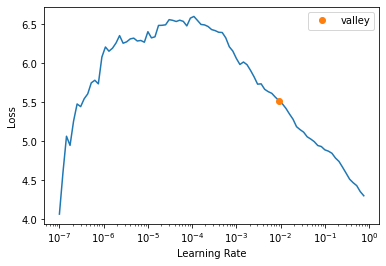

<Figure size 720x720 with 0 Axes>

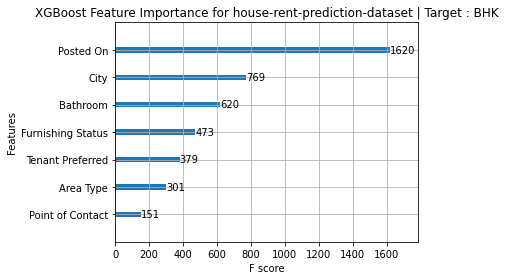

<Figure size 432x288 with 0 Axes>

In [15]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

            feature  importance
0          Bathroom         620
1              City         769
2  Point of Contact         151
3         Posted On        1620
4         Area Type         301


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

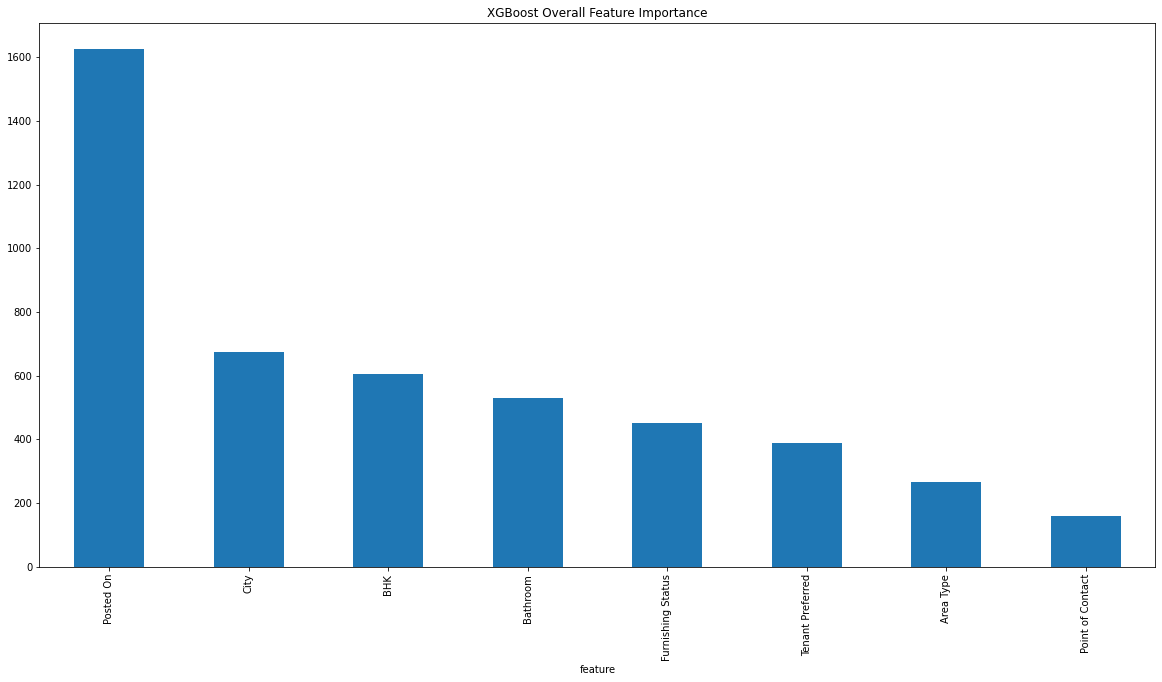

In [16]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [17]:
df.isna().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

# **To Be Continued...**